## _Step 0:_ Imports and loading data

We used only the libraries that we already used during the exercise sessions.

In [75]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind

In [76]:
# Defining constants
DATA_FOLDER = 'data/'
PAPERS_DATASET_PATH = DATA_FOLDER + 'dataset_final.csv'
PROPENSITY_SCORES_PATH = DATA_FOLDER + 'propensity_scores.csv'

In [77]:
# Reading the papers' dataset and having a look at it
df = pd.read_csv(PAPERS_DATASET_PATH)
df.sample(10) 

,year,paper,authors,ratings,decisions,institution,csranking,categories,authors_citations,authors_publications,authors_hindex,arxiv
2112,2019,Using Deep Siamese Neural Networks to Speed up...,Nicholas Roberts;Poornav S. Purushothama;Visha...,3.666667,Reject,"University of California, San Diego;;Universit...",11;-1;11;11;-1;11;11,0,10;0;10;10;184;7944;10968,11;1;4;6;26;312;312,2;0;2;2;7;42;43,False
4211,2020,TinyBERT: Distilling BERT for Natural Language...,Xiaoqi Jiao;Yichun Yin;Lifeng Shang;Xin Jiang;...,5.666667,Reject,Hong Kong University of Science and Technology...,39;-1;-1;-1;-1;-1;39;-1,3,70;59;1733;663;290;826;115;360,3;3;41;23;59;158;22;89,3;1;15;9;7;14;5;9,True
776,2018,Faster Reinforcement Learning with Expert Stat...,Xiaoxiao Guo;Shiyu Chang;Mo Yu;Miao Liu;Gerald...,5.666667,Reject,International Business Machines;International ...,-1;-1;-1,0,1550;2903;3506;1944;7937,43;111;71;198;124,13;28;26;20;45,False
2633,2020,Linear Symmetric Quantization of Neural Networ...,Xiandong Zhao;Ying Wang;Xuyi Cai;Cheng Liu;Lei...,5.000000,Accept,"Institute of Computing Technology, Chinese Aca...",59;59;59;59;59,2,31;-1;3;266;243,19;-1;2;51;82,4;-1;1;7;5,False
4168,2020,Training Data Distribution Search with Ensembl...,Kashyap Chitta;Jose M. Alvarez;Elmar Haussmann...,4.333333,Reject,"Max Planck Institute for Intelligent Systems, ...",-1;-1;-1;-1,0,36;976;471;5914,15;51;21;28,4;15;11;17,True
2495,2020,Adaptive Correlated Monte Carlo for Contextual...,Xinjie Fan;Yizhe Zhang;Zhendong Wang;Mingyuan ...,6.666667,Accept,"University of Texas, Austin;Microsoft;Columbia...",22;-1;15;22,0,35;1561;3;2033,4;79;4;115,2;17;1;24,False
2041,2019,"S-System, Geometry, Learning, and Optimization...",Shuai Li;Kui Jia,4.000000,Reject,;South China University of Technology,-1;478,1,7660;2777,515;75,47;25,False
2406,2020,Quantum Algorithms for Deep Convolutional Neur...,Iordanis Kerenidis;Jonas Landman;Anupam Prakash,7.000000,Accept,Université Paris Diderot;Universite Paris Dide...,481;481;481,0,1603;26;616,100;3;39,22;2;11,False
2262,2020,Meta-Dataset: A Dataset of Datasets for Learni...,Eleni Triantafillou;Tyler Zhu;Vincent Dumoulin...,5.666667,Accept,"Department of Computer Science, University of ...",18;-1;-1;-1;-1;5;-1;-1;-1;-1;-1,6;8,591;440;8319;6550;-1;7537;1679;231;5797;9307;2...,31;5;22;13;-1;19;14;6;52;13;124,9;3;17;12;-1;11;9;5;23;8;44,True
2598,2020,Imitation Learning via Off-Policy Distribution...,Ilya Kostrikov;Ofir Nachum;Jonathan Tompson,6.000000,Accept,New York University;Google;Google,25;-1;-1,0,617;1060;3247,15;42;30,9;15;16,False


## _Step 1:_ Predicting paper ratings

### Task 1.1

#### *Subtask* 1.1.1

Firstly, we inspect the missing data for the three mentioned columns. We observe that there seems to be some papers for which the scores of one or more authors are missing.
We consider the following approaches:
1. Replace the missing values with the mean of the non-missing values, and compute the median of the resulting list.
2. Compute the median including the missing values.
3. Discard the missing values, and only then compute the median.


After giving it some thought, we ran into some issues with the two first approaches:
1. Since we are interested in the median, replacing the missing values with the mean of the related list would not make much sense, because this could result in taking this mean as median for many columns.
2. Computing the median without discarding the missing values skews the median.

The third approach seems to be the most sensible out of the three, but we need to check whether there's a row with all the values equal to '-1' for one of the fields we are taking into account.

First of all let's see how many null values we have.

In [4]:
# Defining the columns to take into account for the computation of the requested fields
authors_columns = ['authors_citations', 'authors_publications', 'authors_hindex']

# Printing the number of missing values for each of the afore-mentioned columns
for author_column in authors_columns:
    print(f'Missing values for {author_column}: {np.squeeze(df[df[author_column].str.contains("-1")][[author_column]].count().values)}')

Missing values for authors_citations: 96
Missing values for authors_publications: 96
Missing values for authors_hindex: 96


Now we turn the semi-colon separated string into a list of numbers, replacing _-1_'s with `np.nan`. This makes the subsequent tasks less tedious. Then, we generate the requested columns.

In [5]:
def convert(df, columns, type_, value=np.nan):
    """
    Converts a column with multiple values in each cell separated by a ';' into a column of numpy arrays, casting the obtained strings into the specified type, if they are not equal to '-1'. 
    Otherwise, substitute that string with the parameter specified as value.
    
    :param df: the dataframe that contains the columns you want to convert
    :type df: pandas.DataFrame
    :param columns: list of columns which contain the values you want to convert
    :type columns: list
    :param type_: type of the converted values of the new list. Casting is done after splitting.
    :type type_: function
    :param value: the value to use to replace "-1".
    :type value: Any, optional
    """
    
    for column in columns:
        df[column] = df[column].apply(lambda x: np.array(list(map(lambda a : type_(a) if type_(a) != -1 else value, x.split(';')))))

In [6]:
# Converting the columns 'authors_citations', 'authors_publications', 'authors_hindex'
convert(df, authors_columns, int)

In [8]:
# For each previously-defined column, create the respective "median column"
for column in authors_columns:
    df[column + '_median'] = df[column].apply(lambda x: np.nanmedian(x))

Before moving on, let's see if there's a paper for which one of the newly generated columns is `np.nan`.

In [9]:
for column in authors_columns:
    col = column + '_median'
    print(f"Number of NaN values in the column {col}: {df[col].isna().sum()}")

Number of NaN values in the column authors_citations_median: 0
Number of NaN values in the column authors_publications_median: 0
Number of NaN values in the column authors_hindex_median: 0


Perfect, we can move on to the next tasks.

#### *Subtask* 1.1.2

We apply the formula, and since we substitued -1 values with `np.nan` in `authors_citations` and `authors_publications`, we check whether the new column has NaN values (since a computation with a NaN value always return NaN). Thankfully, this is not the case. We check again because we only use the last value of the list here, which can be NaN (unlikely, but we want to be sure).

In [12]:
# Creating the reputation column
df['reputation'] = df.apply(lambda x: np.log10((x['authors_citations'][-1] / x['authors_publications'][-1]) + 1), axis=1)

In [13]:
# Checking if one or more reputations are NaN.
df['reputation'].isna().sum()

0

#### *Subtask* 1.1.3

We apply the convert function that turns semi-colon separated strings into an array of elements of the specified type, as done in subtask 1.1.1.

In [14]:
# Applying the conversion to the columns 'institution' and 'csranking'. For 'csranking' we substitute the -1 values with np.inf, as explained below.
convert(df, ['institution'], str)
convert(df, ['csranking'], int, np.inf)

First, let's start with some observations:
1. Companies and institutions are both present in the `institution` column.
2. The same institution can be spelled in different ways.

Fortunately, we solve the first issue by replacing the value -1 with `np.inf`, so that companies do not interfere in the ranking of institutions. This also deals with institutions for which a ranking was not specified.
As for the second observation, we take advantage of the fact that despite different spellings, the ranking is identical. Hence, we build an intermediate dictionary, with different institution spellings as keys and rankings as values, and then we select the keys of the dictionary for which the value is less than or equal to 10.

In [15]:
# Building the aforementioned dictionary. Key: institution name, Value: ranking
ranking = dict(zip(np.hstack(df['institution'].values), np.hstack(df['csranking'].values)))

# Sorting the dictionary keys according to their respective values
ranking = {k: v for k, v in sorted(ranking.items(), key=lambda item: item[1])}

# Selecting the top 10 institutions and printing them
top10_institutions = [k for k,v in ranking.items() if v < 11]
top10_institutions

['Carnegie Mellon University',
 'Carnegie-Mellon University',
 'Massachusetts Institute of Technology',
 'University of Illinois, Urbana Champaign',
 'University of Illinois at Urbana-Champaign',
 'University of Illinois, Urbana-Champaign',
 'Stanford University',
 'University of California Berkeley',
 'University of California-Berkeley',
 'University of Washington',
 'University of Washington, Seattle',
 'Cornell University',
 'University of Michigan',
 'Tsinghua University',
 'Tsinghua',
 'Mails.tsinghua',
 'Swiss Federal Institute of Technology']

Finally, to generate the desired columns, i.e `has_top_institution` and `has_top_company`, we check whether the intersection of each row of `institution` with the array `top10_institutions` and `top_companies` respectively are empty or not.
__Note__: we noticed that somethimes the R&D departments of top companies like Facebook and Microsoft are called in a different way in the dataset ("Facebook AI Research", "Microsoft Research"). We decide to also take into account those when building the feature `has_top_company`. 

In [16]:
# Checking whether the four given top companies are spelled in different ways, like the institutions
top_companies = []
df['institution'].apply(lambda x: [top_companies.append(a) for a in x for b in ["Facebook", "Google", "Microsoft", "Deepmind"] if b in a])

# Creating the top-companies list and printing it
top_companies = list(set(top_companies))
top_companies

['Facebook',
 'Microsoft Research',
 'Facebook AI Research',
 'Google',
 'Microsoft']

Apparently Deepmind is not in the dataset, weird, but we checked in many different ways. Anyway, let's create the columns.

In [17]:
# Creating the two columns 'has_top_company' and 'has_top_institution'
df['has_top_company'] = df['institution'].apply(lambda x: 1 if len(np.intersect1d(x, top_companies)) > 0 else 0)
df['has_top_institution'] = df['institution'].apply(lambda x: 1 if len(np.intersect1d(x, top10_institutions)) > 0 else 0)

Let's see the result:

In [18]:
df.sample(5)

,year,paper,authors,ratings,decisions,institution,csranking,categories,authors_citations,authors_publications,authors_hindex,arxiv,authors_citations_median,authors_publications_median,authors_hindex_median,reputation,has_top_company,has_top_institution
1458,2019,The Importance of Norm Regularization in Linea...,Yihan Gao;Chao Zhang;Jian Peng;Aditya Paramesw...,5.000000,Reject,"[University of Illinois, Urbana Champaign, Uni...","[3, 3, 3, 3]",10;1;8,"[144, 2166, 1316, 155]","[20, 255, 151, 28]","[6, 22, 19, 5]",True,735.5,89.5,12.5,0.815293,0,1
647,2018,"LSD-Net: Look, Step and Detect for Joint Navig...",N dinesh reddy,4.333333,Reject,[Carnegie Mellon University],[1],0,[108],[15],[6],False,108.0,15.0,6.0,0.913814,0,1
768,2018,Jiffy: A Convolutional Approach to Learning Ti...,Divya Shanmugam;Davis Blalock;John Guttag,6.000000,Reject,"[Massachusetts Institute of Technology, Massac...","[2, 2, 2]",0,"[7, 57, 9428]","[5, 8, 220]","[1, 4, 46]",False,57.0,8.0,4.0,1.642015,0,1
1952,2019,Computation-Efficient Quantization Method for ...,Parichay Kapoor;Dongsoo Lee;Byeongwook Kim;Sae...,4.666667,Reject,"[, Samsung, , Samsung]","[inf, inf, inf, inf]",0,"[15, 331, 23, 2]","[6, 33, 10, 2]","[2, 10, 3, 1]",False,19.0,8.0,2.5,0.301030,0,0
3926,2020,On the expected running time of nonconvex opti...,Thomas Flynn;Kwang Min Yu;Abid Malik;Shinjae Y...,4.000000,Reject,"[Brookhaven National Laboratory, Brookhaven Na...","[inf, inf, inf, inf, inf]",1;9;8,"[643, 40, 48, 697, 7]","[91, 31, 9, 79, 5]","[11, 4, 2, 13, 2]",False,48.0,31.0,4.0,0.380211,0,0


#### *Subtask* 1.1.4
We discussed the possible apporaches to solve this in __subtask 1.1.1__. Please refer to it.

### Task 1.2

#### *Subtask* 1.2.1

To randomly split the data into a train and a test set, we simply sample from the dataframe 70% of the rows (_train set_) and then we take the remaining ones as _test set_.

In [19]:
def random_split(data, frac, seed = 0):
    """
    This function returns a train and a test set with random entries chosen from the given dataset.
    The parameter frac represent the fraction of training samples and 1-frac the one of test samples. 
    
    :param data: the complete dataset to split
    :type data: pandas.DataFrame
    :param frac: the fraction of training samples to return, with respect to the entire dataset. It goes from 0 to 1.
    :type frac: float
    :param seed: the seed that indicates the random state for the random sampling
    :type seed: int, optional
    
    :return: the train and the test datasets
    :rtype: tuple
    """
    
    train = data.sample(frac = frac,random_state=seed)
    test = data.drop(train.index)
    
    return train, test 

In [20]:
# Performing the random split of the dataframe and printing the shape of the training and test set
train, test = random_split(df, frac = 0.7)
print(f"Train set shape: {train.shape}\nTest set shape: {test.shape}")

Train set shape: (2979, 18)
Test set shape: (1277, 18)


To be sure that the intersection between the train and the test set is empty, let's see what happens when we merge the two dataframes on the paper name.

In [21]:
check = train.merge(test, on = 'paper')
check

,year_x,paper,authors_x,ratings_x,decisions_x,institution_x,csranking_x,categories_x,authors_citations_x,authors_publications_x,...,authors_citations_y,authors_publications_y,authors_hindex_y,arxiv_y,authors_citations_median_y,authors_publications_median_y,authors_hindex_median_y,reputation_y,has_top_company_y,has_top_institution_y
0,2020,Unified recurrent network for many feature types,Alexander Stec;Diego Klabjan;Jean Utke,1.000000,Reject,"[Northwestern University, Northwestern Univers...","[44.0, 44.0, inf]",0,"[12, 2780, 1067]","[7, 219, 67]",...,"[12, 2625, 1024]","[7, 215, 66]","[1, 26, 14]",False,1024.0,66.0,14.0,1.217883,0,0
1,2019,"Deep Imitative Models for Flexible Inference, ...",Nicholas Rhinehart;Rowan McAllister;Sergey Levine,5.666667,Reject,"[Carnegie Mellon University, University of Cal...","[1, 5, 5]",0,"[378, 556, 24386]","[21, 29, 309]",...,"[390, 576, 24893]","[22, 29, 310]","[9, 11, 74]",False,576.0,29.0,11.0,1.910091,0,1
2,2018,Data augmentation instead of explicit regulari...,Alex Hernández-García;Peter König,5.000000,Reject,"[University of Osnabrück, University of Osnabr...","[364, 364]",8,"[86, 749]","[15, 135]",...,"[87, 780]","[15, 135]","[5, 18]",False,433.5,75.0,11.5,0.831087,0,0
3,2020,Double Neural Counterfactual Regret Minimization,Hui Li;Kailiang Hu;Shaohua Zhang;Yuan Qi;Le Song,7.000000,Accept,[Alibaba Group and Ant Financial Services Grou...,"[inf, inf, inf, inf, 13.0]",0,"[15391.0, 11.0, nan, 6302.0, 9519.0]","[1304.0, 4.0, nan, 253.0, 329.0]",...,"[14710, 11, 9, 12260, 6119, 9290]","[1304, 4, 2, 803, 253, 329]","[54, 2, 1, 50, 32, 52]",False,7704.5,291.0,41.0,1.465934,0,0


Ok, we expected an empty dataframe, what is going on? The answer is that the same paper can be presented more than once, indeed, if we see the year of submission, we get the following.

In [22]:
check[['paper', 'year_x', 'year_y']]

,paper,year_x,year_y
0,Unified recurrent network for many feature types,2020,2019
1,"Deep Imitative Models for Flexible Inference, ...",2019,2020
2,Data augmentation instead of explicit regulari...,2018,2020
3,Double Neural Counterfactual Regret Minimization,2020,2019


The split is not wrong: we need to consider those submissions as independent, even if the paper is the same, since the decision might be different, as well as the scores. But we had to point this out.

#### *Subtask* 1.2.2

Let's longitudinally split the dataset, taking the articles written before the year 2020 as training, and the 2020 ones as test. As you can see, this means that roughly 50% of the articles will be used to train the following models.

In [23]:
# Performing the longitudinal split
train_longitudinal = df[ (df['year'] != 2020) ]
test_longitudinal = df.drop(train_longitudinal.index)

# Printing the shape of the result
print(f"Train longitudinal set shape: {train_longitudinal.shape}\nTest longitudinal set shape: {test_longitudinal.shape}")

Train longitudinal set shape: (2204, 18)
Test longitudinal set shape: (2052, 18)


### Task 1.3

Firstly, we build X (feature matrix) and Y (labels) from the two previous splits, and we create the two models. To create the model, we standardize the data, to have the same scale for every considered feature.

In [24]:
def get_data_and_label(train, test, features, label):
    """
    Given a training and a testing dataset, splits them into X_train (the training feature matrix), X_test (the testing feature matrix), Y_train(the training labels) and Y_test (the testing labels).
    Only the column specified as features will be kept in the feature matrix, the other columns of the dataframes will be dropped.
    
    :param train: the training dataset
    :type train: pandas.DataFrame
    :param test: the testing dataset
    :type test: pandas.DataFrame
    :param features: list of features (columns of the two dataframes) that will be used to make the prediction
    :type features: list
    :param label: the label (column of the two dataframes) we want to predict
    :type label: str
    
    :return: The training and test feature matrices and label vectors
    :rtype: tuple
    """
    
    X_train = train[features]
    Y_train = train[label]
    X_test = test[features]
    Y_test = test[label]
    
    return X_train, X_test, Y_train, Y_test


def standardize (X_train, X_test, columns_exception = []):
    """
    Function to standardize the train and test data of a model.
    
    :param X_train: the training feature matrix
    :type X_train: pandas.DataFrame
    :param X_test: the test feature matrix
    :type X_test: pandas.DataFrame
    :param columns_exception: the features that we don't want to standardize (E.g. binary features)
    :type columns_exception: list
    """
    # Initializing the standardized dataframes
    X_train_std = pd.DataFrame()
    X_test_std = pd.DataFrame()
    
    # Standardizing the data
    for column in X_train.columns:
        if not column in columns_exception:
            
            # Computing the mean and the std on the training set
            mean = X_train[column].mean()
            std = X_train[column].std()
            
            # Standardizing the training and the test set with the values computed on the training set
            X_train_std[column] = (X_train[column] - mean) / std
            X_test_std[column] = (X_test[column] - mean) / std
        else:
            X_train_std[column] = X_train[column]
            X_test_std[column] = X_test[column]
            
    return X_train_std, X_test_std
    

def build_model(X_train, Y_train, X_test, Y_test):
    """
    Given a training and a test feature matrix, with the corresponding label vectors, this function builds a linear regression model, 
    fits it with the training data and tests it over the testing data, returning the predicted labels and the corresponding R2 (R squared) score.
    
    :param X_train: the training feature matrix
    :type X_train: pandas.DataFrame
    :param Y_train: The training label vector
    :type Y_train: pandas.Series
    :param X_test: the test feature matrix
    :type X_test: pandas.DataFrame
    :param Y_test: the test label vector
    :type Y_test: pandas.Series
    
    :return: the prediction made on the test dataset and the related R2 (R squared) score.
    :rtype: tuple
    """
    
            
    # Initializing the linear regression model
    linear = LinearRegression()
    
    # Fitting (training) the model
    linear.fit(X_train, Y_train)
    
    # Predicting the labels of the test samples
    Y_pred = linear.predict(X_test)
    
    # Computing the R2 score for the prediction
    r2 = metrics.r2_score(Y_test, Y_pred)
    
    # De-standardizing the result
    
    return Y_pred, r2

In [25]:
# Declaring the columns that will be used to make the prediction
feature_cols = ['authors_citations_median', 'authors_publications_median', 'authors_hindex_median', 'reputation'] 

# Getting the feature matrices (training and test) and their respective label vectors for the dataframes obtained with the random split
X_train_random, X_test_random, Y_train_random, Y_test_random = get_data_and_label(train, test, feature_cols, 'ratings')

#Standardizing the data (random split)
X_train_random_std, X_test_random_std = standardize(X_train_random, X_test_random)

# Getting the feature matrices (training and test) and their respective label vectors for the dataframes obtained with the longitudinal split
X_train_long, X_test_long, Y_train_long, Y_test_long = get_data_and_label(train_longitudinal, test_longitudinal, feature_cols, 'ratings')

#Standardizing the data (longitudinal split)
X_train_long_std, X_test_long_std = standardize(X_train_long, X_test_long)

In [26]:
# Predicting the labels of the test datapoints (RANDOM SPLIT) and computing the respective R2 score
Y_pred_random, r2_random = build_model(X_train_random_std, Y_train_random, X_test_random_std, Y_test_random)

# Predicting the labels of the test datapoints (LONGITUDINAL SPLIT) and computing the respective R2 score
Y_pred_long, r2_long = build_model(X_train_long_std, Y_train_long, X_test_long_std, Y_test_long)

#### *Subtask* 1.3.1

We now report the $R^2$ score for the two models and, for better understand what is going on, we plot the predicted values against the real values for the test set. The $R^2$ scores, and the two plots, clearly show that a linear model is not the right path to follow in this case.

In [28]:
print(f"Random split R squared (Linear Regressor): {r2_random}\nLongitudinal split R squared (Linear Regressor): {r2_long}")

Random split R squared (Linear Regressor): 0.08690868491765014
Longitudinal split R squared (Linear Regressor): -0.24009712493164104


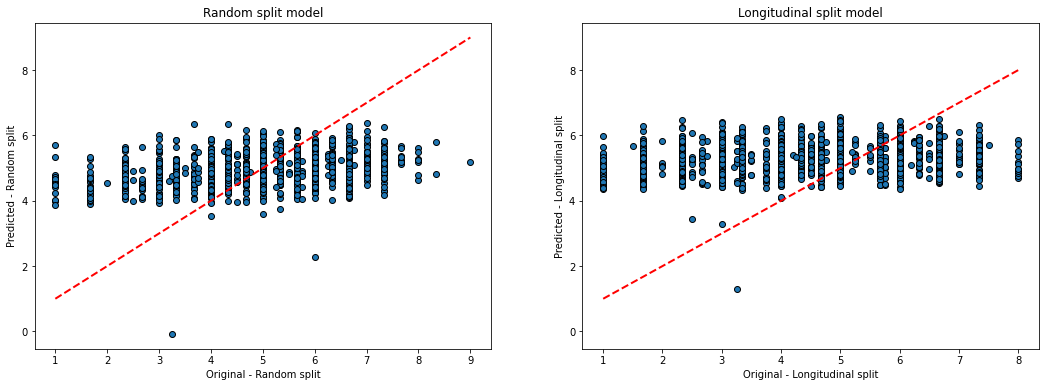

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey = True)

# Plotting the first model predictions
ax[0].scatter(Y_test_random, Y_pred_random, edgecolors=(0, 0, 0))
ax[0].plot([min(Y_test_random), max(Y_test_random)], [min(Y_test_random), max(Y_test_random)], 'r--', lw=2)
ax[0].set_xlabel('Original - Random split')
ax[0].set_ylabel('Predicted - Random split')
ax[0].set_title('Random split model')

#Plotting the second model predictions
ax[1].scatter(Y_test_long, Y_pred_long, edgecolors=(0, 0, 0))
ax[1].plot([min(Y_test_long), max(Y_test_long)], [min(Y_test_long), max(Y_test_long)], 'r--', lw=2)
ax[1].set_xlabel('Original - Longitudinal split')
ax[1].set_ylabel('Predicted - Longitudinal split')
ax[1].set_title('Longitudinal split model')
ax[1].yaxis.set_tick_params(labelleft=True)

plt.show()

#### *Subtask* 1.3.2

_Why are the results different?_

In the first case, the split is random, and the proportion between the train set and the test set is 70:30. In the second case, as we can notice from **Subtask 1.2.2**, the proportion between the two sets is almost 50:50. This means that the second model has less datapoints for training. However, we tried a random split with proportion 50:50, and the results are comparable with the ones obtained with the first model (random split 70:30) in terms of $R^2$ scores. Given that, it could be that the year 2020 is extremely different from the years 2018 and 2019 in terms of the correlation between the features taken into account and the average score of the paper. This means that, in the second case (longitudinal split), the model is trained on some data, and is tested on data which doesn't follow the same "correlation function".  

To prove what we are claiming, this is what happens with a random 50:50 split.

In [30]:
# Splitting the dataset (50% train, 50% test, random split)
train_50, test_50 = random_split(df, frac = 0.5)

# Getting the features and the labels for the two sets
X_train_random_50, X_test_random_50, Y_train_random_50, Y_test_random_50 = get_data_and_label(train_50, test_50, feature_cols, 'ratings')

#Standardizing the data
X_train_50_std, X_test_50_std = standardize(X_train_random_50, X_test_random_50)

# Creating the model and making the prediction
_, r2_random_50 = build_model(X_train_50_std, Y_train_random_50, X_test_50_std, Y_test_random_50)

# Printing the result
print(f"R squared score for a random 50:50 split (Linear Regressor): {r2_random_50}")

R squared score for a random 50:50 split (Linear Regressor): 0.08092997144610736


_So, why, in the second model the $R^2$ score is negative? And what does that mean?_

A negative $R^2$ is possible. The $R^2$ compares the fit of the model with the one of a horizontal line, representing the mean of the training labels. This corresponds to the question: "what happens if I always predict the mean of the training labels for every test datapoint"? In other words: what if the labels and the features are not correlated?
If the $R^2$ is negative, it means that always predicting the aforementioned mean would be a better prediction than the one made by the model. Indeed, given the $R^2$ formulation:

### <center> $R^2$ = $1- \frac{RSS}{TSS}$ </center>

Where RSS and TSS are defined as:

### <center> $RSS$ = $\sum_{i = 1}^{N} (Y_i - \hat{Y_i})^2 $ </center>
### <center> $TSS$ = $\sum_{i = 1}^{N} (Y_i - \overline{Y})^2 $ </center>

Where $\hat{Y_i}$ are the predicted values, $Y_i$ are the true values and $\overline{Y}$ is the mean of the training labels, if the predicted labels are equal to the mean of the training labels ($\hat{Y_i}$ = $\overline{Y}$ for each i)
RSS = TSS and thus $R^2$ = 0, which means that the model doesn't explain the data. In our second case RSS > TSS, so the predicted values are worse than predicting the mean, and so $R^2$ < 0.

As said before, this could happen because the data from 2018 and 2019 are drastically different from the ones from 2020, in terms of correlation between the average score of the papers and the authors-related features that we have taken into account, so making prediction for the year 2020 trough a model built on 2018 and 2019 data is not a good idea. Anyway, since even the $R^2$ value of the first model is close to 0, we can state that, in general, using the aforementioned features to train a **linear** regression model to predict papers' scores doesn't give good results. Maybe a more complex model would lead to better predictions.

#### *Subtask* 1.3.3

We plot the residuals distribution. Then we compute the probability for a residual to be higher than 2 or lower than -2 (which means that the prediction, in that case, is off by more than two points). 
We provide three confident intervals: 90%, 95%, 99% which are computed using the following function. For each bootstrapped set (with replacement), 50% of the data is taken into account.

In [31]:
def residual_CI(data, percentage, n_draws = 1000):
    """
    Computes the confidence interval at the specified percentage for the residuals of being off by more than two points.
    
    :param data: array of values on which compute the confidence interval
    :type data: numpy.ndarray
    :param percentage: the percentage of the confidence interval
    :type percentage: int
    :param n_draw: the number of draws to compute
    :type n_draw: int, optional
    
    :return: the confidence interval
    :rtype: list
    """
    
    # Declaring the list of the probabilities computed on each draw
    values = []
    
    for n in range(n_draws):
        
        # Shuffling the data and creating the set
        indices = np.random.randint(0, len(data), len(data))
        d = data[indices]
        
        # Computing the probability of a prediction being off by more than two points for the bootstrapped set
        values.append((np.abs(d) > 2).sum() / len(d))
        
    percentile = (100 - percentage) / 2
    
    return [np.nanpercentile(values, percentile), np.nanpercentile(values, percentage + percentile)]

Probability of being off by more than two points: 0.1558339859044636
90% Confidence interval: [0.14017227877838684, 0.17149569303054032]
95% Confidence interval: [0.13547376664056382, 0.17621378230227092]
99% Confidence interval: [0.12606891151135474, 0.18089663273296788]


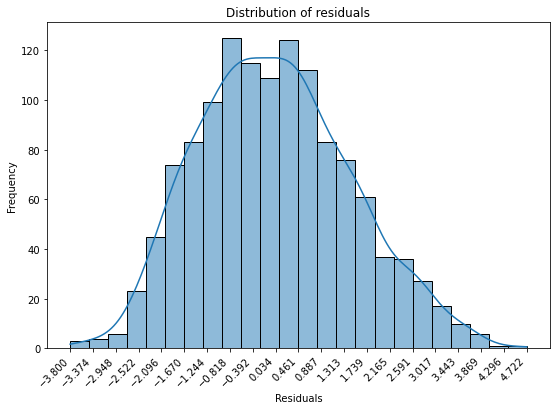

In [32]:
#Computing the residuals
residuals = (Y_pred_random - Y_test_random)

# Plotting the distribution of residuals
fig = plt.figure(figsize =(9,6))
sns.histplot(residuals,kde=True)
plt.title("Distribution of residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.xticks(np.linspace(min(residuals),max(residuals),len(residuals)//60),rotation=45,ha="right");

# Computing the probability of being off by more than two points (over the entire residuals list)
probability_off = (np.abs(residuals.values) > 2).sum() / len(residuals.values)

# Printing the aforementioned probability, with three confidence intervals (90%, 95%, 99%)
print(f"Probability of being off by more than two points: {probability_off}")
print(f"90% Confidence interval: {residual_CI(residuals.values, 90)}")
print(f"95% Confidence interval: {residual_CI(residuals.values, 95)}")
print(f"99% Confidence interval: {residual_CI(residuals.values, 99)}")

#### *Subtask* 1.3.4

__Honestly this task is a bit unclear: by "already computed features" did you mean until this point or in the original dataset? Since we had to make a choice, we interpreted this request as "already computed features until this point", hoping this is what you meant. Now, back to the task!__

One could argue that a feature with high predictive power is one that correlates strongly with the outcome. 

* Intuitively, if a top company or top institution was involved in the writing of a paper, we could assume that the paper produced would be of higher quality, and
  therefore would get a higher rating. 
  For this reason, we could consider the previously computed features ```has_top_company``` and ```has_top_institution```.
*  Additionally, we notice a sharp decline in the mean ratings of papers from 2019 to 2020:
   
    -  2019 : 5.445812807881769
    -  2020:  4.435916179337229 
    
   We could therefore gauge the influence of the ```year``` of publication of a paper by also adding it as a covariate.
  

####  *Subtask* 1.3.5

In [33]:
# Defining new set of features
augmented_features = feature_cols + ["has_top_company","has_top_institution","year"]

# Defining data and labels
X_train_augmented,X_test_augmented,Y_train_augmented, Y_test_augmented = get_data_and_label(train, test, augmented_features, 'ratings')

#Standardizing the data
X_train_std_augmented, X_test_std_augmented = standardize(X_train_augmented, X_test_augmented, columns_exception = ["has_top_company","has_top_institution"])

# Training the model and testing it
_,r2_augmented = build_model(X_train_std_augmented,Y_train_augmented,X_test_std_augmented,Y_test_augmented) 

# Printing the result
print(f"R squared score for a random split (70:30) with additional features (Linear Regressor): {r2_augmented}")

R squared score for a random split (70:30) with additional features (Linear Regressor): 0.14795563321203653


Our intuition was correct, as we get a slighlty better coefficient of determination. This implies that a greater portion of the variance could be explained by the covariates present in the model.

### Task 1.4

#### *Subtask* 1.4.1

We train the gradient boosting regressor with no additional parameters, using the same training and test set as before, coming from the 70:30 random split, and we report the $R^2$ score obtained. Unfortunately, we don't notice any significant improvement in the result.

In [34]:
def build_model_gb(X_train, Y_train, X_test, Y_test):
    """
    Given a training and a test feature matrix, with the corresponding label vectors, this function builds a Gradient Boosting Regressor model, 
    fits it with the training data and tests it over the testing data, returning the predicted labels and the corresponding R2 (R squared) score.
    
    :param X_train: the training feature matrix
    :type X_train: pandas.DataFrame
    :param Y_train: The training label vector
    :type Y_train: pandas.Series
    :param X_test: the test feature matrix
    :type X_test: pandas.DataFrame
    :param Y_test: the test label vector
    :type Y_test: pandas.Series
    
    :return: the prediction made on the test dataset and the related R2 (R squared) score.
    :rtype: tuple
    """
    
    # Initializing the Gradient Boosting Regressor model
    gd_boost = GradientBoostingRegressor()
    
    # Fitting (training) the model
    gd_boost.fit(X_train, Y_train)
    
    # Predicting the labels of the test samples
    Y_pred = gd_boost.predict(X_test)
    
    # Computing the R2 score for the prediction
    r2 = metrics.r2_score(Y_test, Y_pred)
    
    return Y_pred, r2

In [35]:
# Creating the model and making the prediction
Y_pred_boost,r2_boost = build_model_gb(X_train_random_std,Y_train_random,X_test_random_std,Y_test_random)

# Printing the result
print(f"R squared score for a random split (Gradient Boosting Regressor): {r2_boost}")

R squared score for a random split (Gradient Boosting Regressor): 0.09978318955651333


#### *Subtask* 1.4.2

We first define the crazy feature in the dataframe.

In [36]:
# Creating the new 'crazy' column
df['crazy'] = np.where(df['ratings'].values>=4.96,9-df['ratings'],-1*df['ratings'])

# Redefining train and test to include 'crazy'
train, test = random_split(df, frac = 0.7)

We then use this new feature as the only feature of our Gradient Boosted Regressor Model.

In [37]:
# Defining the training set and testing set according to the selected feature 'crazy'.
# NOTE: since in this case crazy is the only feature, it is not standardized
X_train_crazy, X_test_crazy, Y_train_crazy, Y_test_crazy  = get_data_and_label(train,test,'crazy','ratings')

# Building the model, performing the predictions and computing the r2 score
# NOTE: Regressor methods do not not accept 1-D arrays for the data (i.e single feature matrix), 
# so we add a 'wrapper' dimension with reshape(-1,1) applied to the values of X_train
Y_pred_crazy_gdb,r2_crazy_gdb = build_model_gb(X_train_crazy.values.reshape(-1,1),Y_train_crazy,X_test_crazy.values.reshape(-1,1),Y_test_crazy)

# Printing the result
print(f"R squared score for a random split with 'crazy' feature (Gradient Boosted Regressor): {r2_crazy_gdb}")

R squared score for a random split with 'crazy' feature (Gradient Boosted Regressor): 0.9999589936595438


The $ R^{2} $ score is indeed impressive ! Let us compare it to the score of a linear regressor.

In [78]:
# Building the model, performing the predictions, and computing the r2 score
Y_pred_crazy_lin,r2_crazy_lin = build_model(X_train_crazy.values.reshape(-1,1),Y_train_crazy,X_test_crazy.values.reshape(-1,1),Y_test_crazy)

# Printing the result
print(f"R squared score for a random split with 'crazy' feature (Linear regressor): {r2_crazy_lin}")

R squared score for a random split with 'crazy' feature (Linear regressor): 0.4125706369245945


#### *Subtask* 1.4.3 

Why are gradient boosted regressors so much better  ? 

The two features (`crazy` and `ratings`) are of course highly correlated, but the function that relates `crazy` to `ratings` is not linear, so a simple linear regressor wouldn't catch this relation entirely. On the other hand, the method that we followed to build the new feature lends itself well to a decision tree classifier, as the ones used in Gradient Boosted Regression, which is no more than a set of decision trees (100 by default, with depth of 3) built on top of each other, in the sense that the output of a tree is used as input for the following one (Boosting approach). `Crazy` is directly related to `ratings` by the following formula: 
 ### <center> $ Crazy =  9 \times \mathbb{1}_{ratings \geq 4.96}  - ratings $

## Task 1.5

#### *Subtask* 1.5.1 

We define a cross_validation method that splits the data into __N__ partitions and performs cross validation. We also define a function to compute the average $R^2$ score and its confidence interval.

In [39]:
def compute_CI(data, percentage, ndraws = 1000):
    """
    This function returns the confidence interval for the mean of a given array. The confidence level is given as a parameter.
    The confidence interval is obtained with the bootstrap technique.
    
    :param data: array of values on which compute the confidence interval and the mean
    :type data: numpy.ndarray
    :param percentage: the percentage of the confidence interval
    :type percentage: int
    :param n_draw: the number of draws to compute
    :type n_draw: int, optional
    
    :return: the confidence interval and the computed mean
    :rtype: tuple
    """

    means = []
    
    # Computing the true mean of the given data.
    true_mean = np.mean(data)
    
    # Sampling/Bootstrapping data
    for n in range(ndraws):
        indices = np.random.randint(0, len(data), len(data))
        d = data[indices]
        means.append(np.nanmean(d))
    
    percentile = (100 - percentage) / 2
    
    return [np.nanpercentile(means, percentile),np.nanpercentile(means, percentage + percentile)], true_mean

In [40]:
def cross_validation(X, Y, K, model):
    """
    Given a model, the number of folds, a feature matrix (the datapoints) and the related labels, this function performs a K-fold cross validation.
    It returns the average R2 score with a 90% confidence interval
    
    :param X: the feature matrix / the datapoints
    :type X: pandas.DataFrame
    :param Y: the labels
    :type Y: pandas.Series
    :param K: the number of folds
    :type K: int
    :param model: the ML model
    :type model: sklearn model
    
    :return: the average R2 (R squared) score and its confidence interval
    :rtype: tuple
    """
    
    # Performing the cross validation
    scores = cross_val_score(model, X, Y, cv = K, scoring = "r2")
    
    # Computing the average R2 score and the related confidence interval
    CI, avg_r2 = compute_CI(scores, 90)
    
    return CI, avg_r2

#### *Subtask* 1.5.2

We decided to use the same features of **subtask 1.3.1** (_'authors_citations_median'_, _'authors_publications_median'_, _'authors_hindex_median'_, _'reputation'_), since no indication has been provided in this sense. 

In [41]:
# Splitting again the data into train and test sets
train, test = random_split(df, frac = 0.7)

# Separating the datapoints from their labels
X_train, X_test, Y_train, Y_test = get_data_and_label(train, test, feature_cols, 'ratings')

#Standardizing the data
X_train_std, X_test_std = standardize(X_train, X_test)

# Declaring the two lists with the number of estimators and all the possible learning rates
n_estimators = [50, 75, 100, 150, 200, 250]
learning_rates = [0.1, 0.05, 0.01]

# This variables will hold the best combination and the best associated R2 score
best_n_estimators = 0
best_learning_rate = 0
best_r2 = 0

# Creating the array for the following visualization
heatmap_array = np.zeros((len(n_estimators), len(learning_rates)))
                      
for i, n_estimator in enumerate(n_estimators):
    for j, learning_rate in enumerate(learning_rates): 
        
        # Initializing the model
        gd_boost = GradientBoostingRegressor(n_estimators=n_estimator, learning_rate=learning_rate)
        
        # Performing the cross validation and computing the result
        CI, avg_r2 = cross_validation(X_train_std, Y_train, 20, gd_boost)
        heatmap_array[i, j] = avg_r2
        
        # Saving the best parameters and their score
        if avg_r2 > best_r2:
            best_r2 = avg_r2
            best_n_estimators = n_estimator
            best_learning_rate = learning_rate
        
        # Printing the results
        print(f"Number of estimators: {n_estimator} - Learning rate: {learning_rate} - Average R squared: {avg_r2} - 90% Confidence interval: {CI}")

Number of estimators: 50 - Learning rate: 0.1 - Average R squared: 0.09904331187377116 - 90% Confidence interval: [0.07612953472637322, 0.12275642143206361]
Number of estimators: 50 - Learning rate: 0.05 - Average R squared: 0.10114199247658133 - 90% Confidence interval: [0.080813461539708, 0.1225640922301677]
Number of estimators: 50 - Learning rate: 0.01 - Average R squared: 0.05536616374383694 - 90% Confidence interval: [0.04443789343454532, 0.06565228082055308]
Number of estimators: 75 - Learning rate: 0.1 - Average R squared: 0.09508145004122426 - 90% Confidence interval: [0.07206606536236754, 0.11899105569755405]
Number of estimators: 75 - Learning rate: 0.05 - Average R squared: 0.10092110895291458 - 90% Confidence interval: [0.07859876458435194, 0.12368268722162745]
Number of estimators: 75 - Learning rate: 0.01 - Average R squared: 0.07026375042614516 - 90% Confidence interval: [0.05697789551691496, 0.08341273304952047]
Number of estimators: 100 - Learning rate: 0.1 - Average 

For a better visualization of this result, let's create a heatmap!

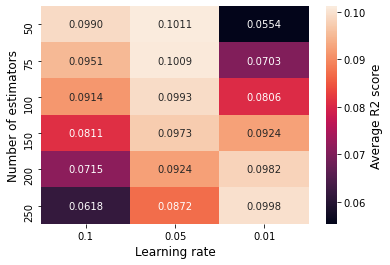

In [42]:
# Plotting a heatmap of average R2 scores in function of the number of estimators and the different learning rates
ax = sns.heatmap(heatmap_array, xticklabels = learning_rates, yticklabels = n_estimators, annot = True, fmt = '.4f', cbar_kws={'label': 'Average R2 score'})
ax.set_xlabel('Learning rate', fontsize = 12)
ax.set_ylabel('Number of estimators', fontsize = 12)
ax.figure.axes[-1].yaxis.label.set_size(12)

#### *Subtask* 1.5.3

Now that we obtained the best hyperparameters combination from the cross validation, let's see how the model performs on the test data.

In [43]:
# Initializing the Gradient Boosting Regressor Model with the best parameters found
gd_boost = GradientBoostingRegressor(n_estimators=best_n_estimators, learning_rate=best_learning_rate)

# Training the model
gd_boost.fit(X_train_std, Y_train)

# Predicting the labels of the test set
Y_pred = gd_boost.predict(X_test_std)

# Computing the R2 score of the prediction
r2 = metrics.r2_score(Y_test, Y_pred)

# Printing the results
print(f"The best parameters between the ones given are:\nNumber of estimators = {best_n_estimators}\nLearning rate = {best_learning_rate}", end = '\n\n')
print(f"The R squared metric for the testing set, with the best parameters of the cross validation, is:{r2}")

The best parameters between the ones given are:
Number of estimators = 50
Learning rate = 0.05

The R squared metric for the testing set, with the best parameters of the cross validation, is:0.10241661714679973


Ok, the result is similar to what we expected.

#### *Subtask* 1.5.4

_Why don't we tune the hyper-parameters in the testing set instead of doing cross-validation in the training set?_

In order to avoid overfitting and to really understand the predictive power of the model, once it has been built and trained, it must be tested on unseen data. For this reason, if we use the test set to obtain the best parameters, we wouldn't have a test set to test the model on! How could we then understand if the model is good to predict over __new, unseen data__, if we don't have some "new data" to use as a test? 

For this reason, cross validation exists: at first we split our data into train and test set. This last set is never seen by the model during the training phase.

Then with k-fold cross validation, the training set is split into k subsets. For each iteration of the algorithm, K-1 are used to train the model, the remaining one to validate it (see how well it behaves). Calling this cross validation multiple times we can tune our hyperparameters, train the model on the entire training set, and then (and only then) test its performance over the test set.

## _Step 2:_ What influences papers getting accepted?

### Task 2.1

#### *Subtask* 2.1.1

At first we create two datasets, one containing the ratings of the papers that got accepted in 2020, the other one containing the ratings of the rejected ones (in the same year). Then, we plot the distribution of those ratings in the two datasets.

In [44]:
# Obtaining the ratings of accepted and rejected papers in 2020
accepted_2020 = df[(df['year'] == 2020) & (df['decisions'] == 'Accept')]['ratings']
rejected_2020 = df[(df['year'] == 2020) & (df['decisions'] == 'Reject')]['ratings']

In [45]:
def plot_dist(ax, title, ylabel, data):
    """
    Plots the distibution of giving data using the histplot function. 
    
    :param ax: the axes of the subplot where to plot the distribution
    :type ax: matplotlib.AxesSubplot
    :param title: the title of the plot
    :type title: str
    :param ylabel: the label for the y axes
    :type ylabel: str
    :param data: the data of which to plot the distribution
    :type data: pandas.Series
    
    """
    
    # Plotting the distribution
    sns.histplot(data, kde=True, ax = ax, stat = 'probability');
    
    # Settings the plot parameters 
    ax.set_title(title, fontsize = 14)
    ax.set_ylabel(ylabel)

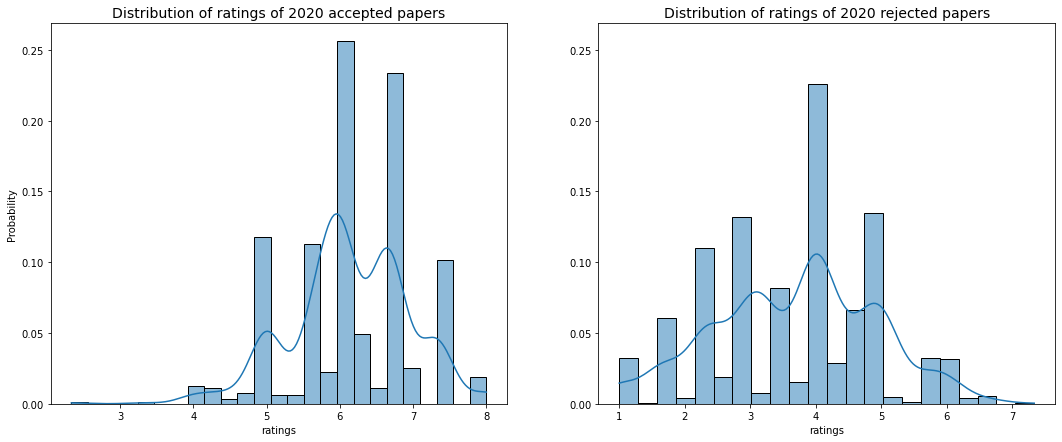

In [46]:
# Defining the figure with the relative subplots 
fig, axs = plt.subplots(1,2, figsize = (18, 7), sharey = True)

# Plotting the distribution of ratings of 2020 accepted papers
plot_dist(axs[0], 'Distribution of ratings of 2020 accepted papers', 'Probability', accepted_2020)

# Plotting the distribution of rating of 2020 rejected papers
plot_dist(axs[1], 'Distribution of ratings of 2020 rejected papers', 'Probability', rejected_2020)
axs[1].yaxis.set_tick_params(labelleft=True)

#### *Subtask* 2.1.2

We want to compare the mean of two indipendent samples. In particular, we are in this situation:

- $H_0$: The mean of the ratings of the papers that got accepted in 2020 is less or equal than the mean of the ratings of the rejected ones. __This is the Null Hypotesis of the test, the one we would like to reject__
- $H_1$: The opposite - the mean of the ratings of the papers that got accepted in 2020 is higher than the mean of the ratings of the rejected ones (same year).

In [47]:
# Computing the t-statistic and the p-value for the hypothesis test
t_value, p_value = ttest_ind(accepted_2020, rejected_2020)

# Showing t-statistic and the p-value (divided by 2 because it is a one tailed test)
print(f"T value: {t_value}, P-value (divided by two for our test): {p_value/2}")

T value: 45.79777665813106, P-value (divided by two for our test): 2.6079785e-316


#### *Subtask* 2.1.3

The ScyPy `ttest_ind` hypothesis test has a slightly different meaning with respect to what we are looking for, but it's still suitable for us. Its null hypothesis is that the mean of the two input distributions is equal (their difference is equal to 0), which means that this is a two tailed test. This means that, if we only looked at the P-value of this test without making more advanced considerations, we wouldn't really gain so much. The function, however, returns also the t-statistic of the test, which we can interptet, but how?

- Let's call A the distrbution of the ratings of the accepted papers in the year 2020
- Let's call B the distribution of the ratings of the rejected papers in the year 2020

We want to reject the hypothesis mean(A) <= mean(B), given samples of the two distributions. So, in our case, we want to check that:

1. The returned P-value, __divided by 2__ is less or equal than a given constant - usually 0.05 in this kind of tests to reject the hypothesys with 95% of confidence -.
2. The returned T-statistic is greater than 0 - this means that the mean of the first distribution (A) minus the mean of the second (B), divided by the standard error of the difference between those means is positive, and thus, since the denominator of this quantity is always positive, the numerator must be __negative or 0__ in order to __NOT reject the null hypothesis__.

As we can see, these two conditions are fulfilled and so we can state with reasonable certainty that the mean of the distribution of the ratings of the papers that got accepted in 2020 (A) is significantly higher than the mean of the distribution of the papers that got rejected in the same year (B). In other words, we reject $H_0$, and the only other possibility is to accept $H_1$.

### Task 2.2

#### *Subtask* 2.2.1

First of all, let's just consider the papers that have been submitted in 2020, and let's transform the `decisions` column into a binary variable that takes:
- 0 $\rightarrow$ Paper rejected
- 1 $\rightarrow$ Paper accepted

Then we standardize the columns `ratings` and `reputation`. The second one will be used in __subtask 2.3.1__ . We do this because the two columns are different in terms of values taken, so they aren't really comparable.

Before standardizing, we store the mean and the standard deviation of both columns in two variables, so that, in __subtask 2.2.2__ and in __task 3.3__, we can standardize the given rating and/or reputation accordingly.

In [48]:
# Creating the dataframe and the binary variable
papers_2020 = df[df['year'] == 2020].replace({'decisions': 'Accept'}, 1).replace({'decisions': 'Reject'}, 0)

# Storing mean and std for ratings
ratings_mean = papers_2020['ratings'].mean()
ratings_std = papers_2020['ratings'].std()

# Storing mean and std for reputation
reputation_mean = papers_2020['reputation'].mean()
reputation_std = papers_2020['reputation'].std()

# Standardizing the colunns ratings and reputation
papers_2020['ratings'] = (papers_2020['ratings'] - ratings_mean) / ratings_std
papers_2020['reputation'] = (papers_2020['reputation'] - reputation_mean) / reputation_std

Now, we can build the model using the logistic regression.

In [49]:
# Building the function for the Logistic Regression (will come in handy also later on)
def logistic_regression(outcome, variables, data):
    """
    Performs the logistic regression for the outcome variable over the independent variables using the specified data.
    
    :param outcome: the dependent variabile
    :type outcome: str
    :param variables: the independent variables
    :type variables: list
    :param data: the dataset on which to build the model
    :type data: pandas.DataFrame
    """
    
    # Building the model
    model = smf.logit(formula=outcome + ' ~ ' + " + ".join(variables), data=data)
    
    # Training the model
    result = model.fit()
    
    # Printing the result
    print(result.summary())

In [52]:
# Building and fitting the logistic regression model, and printing the result
logistic_regression('decisions', ['ratings'], papers_2020)

Optimization terminated successfully.
         Current function value: 0.251882
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              decisions   No. Observations:                 2052
Model:                          Logit   Df Residuals:                     2050
Method:                           MLE   Df Model:                            1
Date:                Thu, 19 Nov 2020   Pseudo R-squ.:                  0.5913
Time:                        15:11:12   Log-Likelihood:                -516.86
converged:                       True   LL-Null:                       -1264.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3803      0.129    -18.428      0.000      -2.633      -2.127
ratings        3.7693      0.

#### *Subtask* 2.2.2

Firstly, let's standardize the 7 in the same way as before.

In [53]:
# Standardizing the number 7 according to the mean and std of the ratings column
standardized_value = (7 - ratings_mean) / ratings_std

# Printing the standardized value
print(f"Standardized value: {standardized_value}")

Standardized value: 1.6103328969568205


In our model we have an intercept of __-2.3803__ and a coefficient for the variable `ratings` of __3.7693__. 
This means that, in this case, the logistic regression gives us the following formula:

### <center> $ ln(\frac{p}{1-p}) =  -2.3803 + r \cdot 3.7693 $ </center>

where p is, of course, the probability for a paper of being accepted.
So, we obtain the following for a rating equals to 7:
    
### <center> $ p = \frac{e^{-2.3803 + 1.61033 \cdot 3.7693}}{1+ e^{-2.3803+ 1.61033 \cdot 3.7693}} = 0.976  $ </center>

Of course this result makes total sense, since, from the previous plots (__subtask 2.1.1__), we can notice that the number of rejected papers with a 7 rating is almost equal to 0, while the number of accepted papers with the same rating is very high.

### Task 2.3

#### *Subtask* 2.3.1

First of all, let's modify the column `arxiv` such that we have integer numbers (1, 0) and not boolean values.

In [54]:
# Converting the feature 'arxiv' to 0 - 1 instead of False - True
papers_2020['arxiv'] = papers_2020['arxiv'].astype(int)

Now, let's create the model and print the result.

Please note: we treated `arxiv` as a categorical variable, not following the given formula, because it actually is categorical. However, the coefficients don't change if we treat the variable as not categorical.

In [55]:
# Building the model, printing the result
logistic_regression('decisions', ['ratings', 'reputation', 'C(arxiv)'], papers_2020)

Optimization terminated successfully.
         Current function value: 0.250440
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              decisions   No. Observations:                 2052
Model:                          Logit   Df Residuals:                     2048
Method:                           MLE   Df Model:                            3
Date:                Thu, 19 Nov 2020   Pseudo R-squ.:                  0.5936
Time:                        15:11:26   Log-Likelihood:                -513.90
converged:                       True   LL-Null:                       -1264.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.4865      0.143    -17.419      0.000      -2.766      -2.207
C(arxiv)[T.1]     0.

#### *Subtask* 2.3.2

We see that the coefficient of the variable `arxiv` is equal to 0.289, which means that, when `arxiv` is equal to one, the odds is multiplied by $ e^{0.289} = 1.3305 $ with respect to the same odds when `arxiv` is equal to 0 and the other variables (`ratings` and `reputation`) are fixed. We observe that this value does not seem to have a significant impact over the odds and, consequently, the probability for a paper to be accepted. Indeed we see that the P value associated to `arxiv` in the regression is equal to 0.084, which is greater than 0.05, so we __cannot__ reject the null hypothesis that `arxiv` is completely uncorrelated with the outcome.


### Task 2.4

#### *Subtask* 2.4.1

In [56]:
# Building the model, printing the result
logistic_regression('decisions', ['ratings', 'reputation', 'C(arxiv)*C(has_top_institution)'], papers_2020)

Optimization terminated successfully.
         Current function value: 0.247320
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              decisions   No. Observations:                 2052
Model:                          Logit   Df Residuals:                     2046
Method:                           MLE   Df Model:                            5
Date:                Thu, 19 Nov 2020   Pseudo R-squ.:                  0.5987
Time:                        15:11:38   Log-Likelihood:                -507.50
converged:                       True   LL-Null:                       -1264.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -

#### *Subtask* 2.4.2

By looking at the P-values of the coefficients of interest, we notice that `arxiv`, `has_top_institution`, and `has_top_institution` * `arxiv` do not seem to be significant in the regression. Indeed:

- P-value of `arxiv` = 0.597
- P-value of `has_top_institution` = 0.103
- P-value of `arxiv` * `has_top_institution` = 0.117

So we can't reject the null hypothesis that those variables are completely uncorrelated with the outcome, and so we have no evidence that pre-printing breaks double-blind submissions.

## Step 3: Matching

### Task 3.1

Firstly, let's just load the propensity scores dataset and have a look at it.

In [57]:
# Loading the propensity scores dataset and printing some samples
propensity_df = pd.read_csv(PROPENSITY_SCORES_PATH)
propensity_df.head()

,paper,propensity_score
0,Pitfalls of In-Domain Uncertainty Estimation a...,0.360486
1,An Inductive Bias for Distances: Neural Nets t...,0.567842
2,Stochastic AUC Maximization with Deep Neural N...,0.334322
3,On the interaction between supervision and sel...,0.402644
4,Towards Better Understanding of Adaptive Gradi...,0.334322


#### *Subtask* 3.1.1

We merge the just loaded dataset with the 2020 papers one, on the paper name.

In [58]:
# Merging the just loaded dataset with the one containing the 2020 papers
df_with_prop = papers_2020.merge(propensity_df, on = 'paper')

#### *Subtask* 3.1.2

The propensity score is not a prediction per se, as we are not testing the resulting "model" on unseen data, simply because this is not our purpose. 
Instead, we want to compute a score for each sample according to a certain set of its features (typically all of them), precisely, the probability for a paper to be pre-printed. As such, we want to compute this value for every sample in our dataset, hence, we lose this notion of training sets and testing sets.

So, in Step 1, we want to create a model to do __predictions__ of the average rating of a new, unseen paper. Therefore, the use of a testing set is necessary to assess the performance of our model. 
In this case, there is no assessment to be done, we just compute a score for known data and that's all we want. If a new sample is given, we cannot use the same model to compute its propensity score, as it is a function of the underlying distribution of the data; i.e, adding a new point would modify the distribution.

### Task 3.2

#### *Subtask* 3.2.1

There are several ways to produce a 1-to-1 matching on the papers, but there are specificities that we need to consider: 
- The treatment set (papers that got pre-printed - 590) is smaller than the control set (papers that did not get pre-printed - 1462). 
- It could be that several papers share some candidates for matching accross the control group and then we should decide which approach to take: 
    1. __Maximizing the number of matchings__: To be clear about the problem, let's make an example: if we decide to store matchings which follow the given constraint ( $|p_{c} - p_t| < \epsilon$ ) in a dictonary like:
    
    `{paper_treatment_id_1:[paper_control_id_1, paper_control_id_2, ...], ...}` 
    
    and we have the following example 
    
    `{1:[50, 10], 2:[70, 20], 3:[70, 50]}`
    
    without any advanced algorithm, let's say we just select the first control paper. So we choose 50 for the first treatment paper, 70 for the second one and we discard the third one (remember that the matching must be 1 to 1). Actually, choosing 10 for the first treatment paper, 70 for the second and 50 for the third, we are able to keep all the treatment papers.
    
    2. __Maximizing the similarity for each matching, considering subsequent matchings__: For instance, if we decide to store data in a dictonary like 
    
    `{paper_treatment_id_1: { paper_control_id_1 : inverse_similarity ,  paper_control_id_2 : inverse_similarity, ... }, ...}` 
    
    where _inverse\_similarity_ is the absolute value of the difference of the treatment paper propensity score and the related control paper propensity score (lower is better), and if we have the following matchings, where each list of possible control papers for each treatment paper is sorted according to the _inverse\_similarity_ score: 
    
    `{1: { 40:0.2 , 50:0.5 } , 2: { 40:0.3 , 50:0.6} , 3: {40:0.4 , 50:0.5}}`
    
    without any advanced algoithm, we just select 40 for the the first treatment paper, 50 for the second one (control paper number 40 is already taken) and we discard the third treatment paper (control papers number 40 and 50 are taken). 
    But if we chose a more sophisticated approach, we can see that chosing the third treatment paper (3) instead of the second one for a match with the control paper number 50 would be globally better.
  
  These problems seem complex to deal with, and are mutually exclusive (either we choose to solve the first one or the second one) so, before trying to implement more advanced algorithms, we try something less fancy. Namely, for each treatment paper, we take the best __local__ control paper (without considering the candidates for the other treatment papers) and we see how good is the matching.

In [59]:
def perform_matching(leaked, non_leaked):
    """
    Performs the matching between the treatment and control group according to the provided propensity score.
    
    :param leaked: treatment group (2020 pre-printed papers)
    :type leaked: pandas.DataFrame
    :param non_leaked: control group (2020 not pre-printed papers)
    :type non_leaked: pandas.DataFrame
    
    :return: the dictonary of treatment and control pairs
    :rtype: dict
    """
    
    # Declaring the dictionary that will store the pairs and the threshold
    matching = {}
    threshold = 0.05

    for index_leak, leak in leaked.iterrows():

        # candidates for the treated paper (leak)
        items = {}

        for index_non_leak, non_leak in non_leaked.iterrows():

            # Computing the inverse-similarity score (lower is better)
            inv_similarity = np.abs(leak['propensity_score'] - non_leak['propensity_score'])

            # If the constraint is respected and the control paper hasn't been already assigned to another treatment paper
            if inv_similarity < threshold and not non_leak['paper'] in list(matching.values()):

                # Adding the control paper to the possible candidates
                items[non_leak['paper']] = np.abs(leak['propensity_score'] - non_leak['propensity_score'])

        # Sorting the list of candidates by inverse-similarity (lower is better)
        items = [k for k, v in sorted(items.items(), key=lambda item: item[1])]

        # Assigning the best control paper to the treatment paper according to the inverse-similarity score
        matching[leak['paper']] = items[0]
        
    return matching

In [60]:
# Let's create our treatment and control groups
leaked = df_with_prop[df_with_prop['arxiv'] == 1]
non_leaked = df_with_prop[df_with_prop['arxiv'] == 0]

# Performing the matching
matching = perform_matching(leaked, non_leaked)

#### *Subtask* 3.2.2

Let's compare the number of treatment papers to which a control paper has been assigned to the total number of treatment papers.

In [61]:
print(f"Total number of treatment papers: {leaked.shape[0]}\nTotal number of treatment papers to which a control paper has been assigned: {len(matching.keys())}")

Total number of treatment papers: 590
Total number of treatment papers to which a control paper has been assigned: 590


Perfect, we managed to assign a control paper to every treated paper. We can then state that our particular situation is not affected by the first of the two problems we have explained before. Let's now compare the distributions of the variables `reputation` and `ratings` among the treatment and the control group!

### Task 3.3

#### *Subtask* 3.3.1

Here we compare the distribution of the variables `reputation` and `ratings` among the treatment and the control group. As we can see the distributions, for both of the variables, are quite similar, so the matching has been successful. At this point, we don't think we should proceed in a more complex fashion for the second problem we explained in __subtask 3.2.1__, since the result is satisfactory. We create a function to plot the results, which will be usefull also for the next tasks. 

_Note that the colors used to plot the result come from a color-blind friendly palette._

In [62]:
def plot_comparison_dist(leaked_data, leaked_label, non_leaked_data, non_leaked_label, title, ax):
    """
    This function is used to plot, on the same axis (the same figure) the distribution of a variable in two dataset (treatment and control group).
    :param leaked_data: the values of the attribute for the first dataset (treatment group)
    :type leaked_data: pandas.Series
    :param leaked_label: the label to show in the legend for the first distribution
    :type leaked_label: str
    :param non_leaked_data: the values of the attribute for the second dataset (control group)
    :type non_leaked_data: pandas.Series
    :param non_leaked_label: the label to show in the legend for the second distribution
    :type non_leaked_label: str
    title: the title of the plot
    :ax: the axis of the figure used to plot the result
    """
    
    # Plotting the two distributions
    sns.histplot(non_leaked_data, label=non_leaked_label, ax = ax, color = '#fc8d59', element = 'step', kde=True, stat= 'probability');
    sns.histplot(leaked_data, label=leaked_label, ax = ax, color = '#91bfdb', element = 'step', kde=True, stat= 'probability');
    ax.set(title=title, ylabel='Probability')
    ax.legend()

In [63]:
# Let's take from the control group of papers (the one that didn't get pre-printed) only the matched ones
control = list(matching.values())
non_leaked_matched = non_leaked[non_leaked['paper'].isin(control)]

# Computing the "true" ratings (without standardization): remember that in a previous task we standardized the data!
non_standardized_leaked_ratings = (leaked['ratings'] * ratings_std) + ratings_mean
non_standardized_non_leaked_ratings_matched = (non_leaked_matched['ratings'] * ratings_std) + ratings_mean
non_standardized_non_leaked_ratings = (non_leaked['ratings'] * ratings_std) + ratings_mean

# Computing the "true" reputations (without standardization): remember that in a previous task we standardized the data!
non_standardized_leaked_reputation = (leaked['reputation'] * ratings_std) + ratings_mean
non_standardized_non_leaked_reputation_matched = (non_leaked_matched['reputation'] * ratings_std) + ratings_mean
non_standardized_non_leaked_reputation = (non_leaked['reputation'] * ratings_std) + ratings_mean

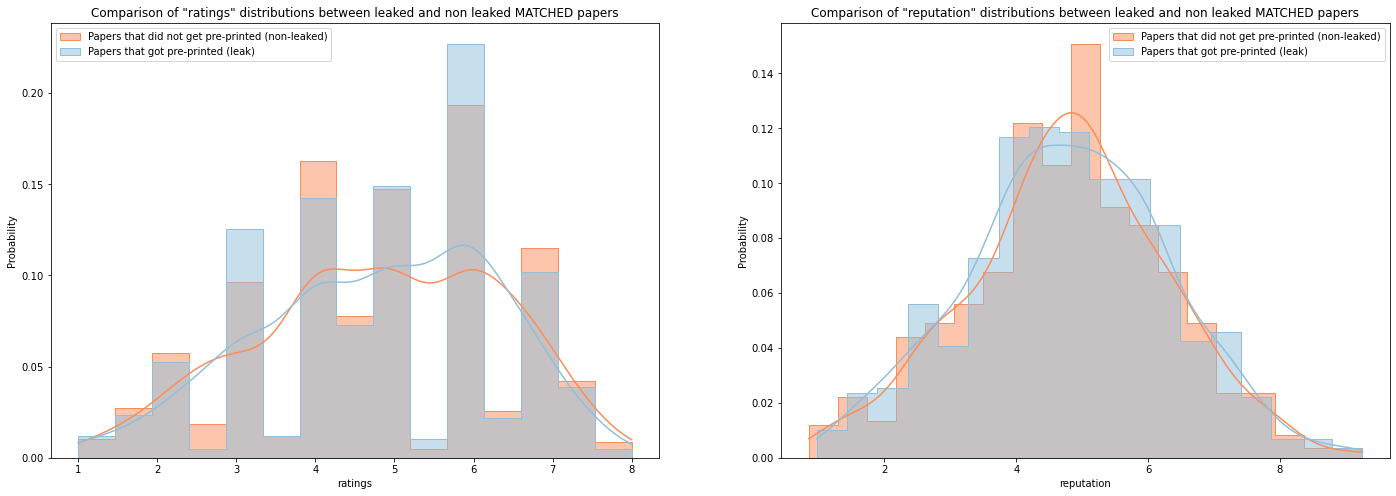

In [64]:
fig, axs = plt.subplots(1, 2, figsize = (24, 8))

# Plotting the comparison of "ratings" distributions between matched papers
plot_comparison_dist(non_standardized_leaked_ratings, 
                     'Papers that got pre-printed (leak)', 
                     non_standardized_non_leaked_ratings_matched, 
                     'Papers that did not get pre-printed (non-leaked)', 
                     'Comparison of "ratings" distributions between leaked and non leaked MATCHED papers',
                     axs[0])
axs[0].legend(loc = 'upper left')

# Plotting the comparison of "reputation" distributions between matched papers
plot_comparison_dist(non_standardized_leaked_reputation, 
                     'Papers that got pre-printed (leak)', 
                     non_standardized_non_leaked_reputation_matched, 
                     'Papers that did not get pre-printed (non-leaked)', 
                     'Comparison of "reputation" distributions between leaked and non leaked MATCHED papers',
                     axs[1])

#### *Subtask* 3.3.2

We can notice that, without the matching process we did, the control papers follow a different distribution (for the variables `reputation` and `ratings`) with respect to the treated ones. Actually we expected a more drastic change, with the help of the matching function, but it's undeniable that the distribution are more similar after the matching than before.

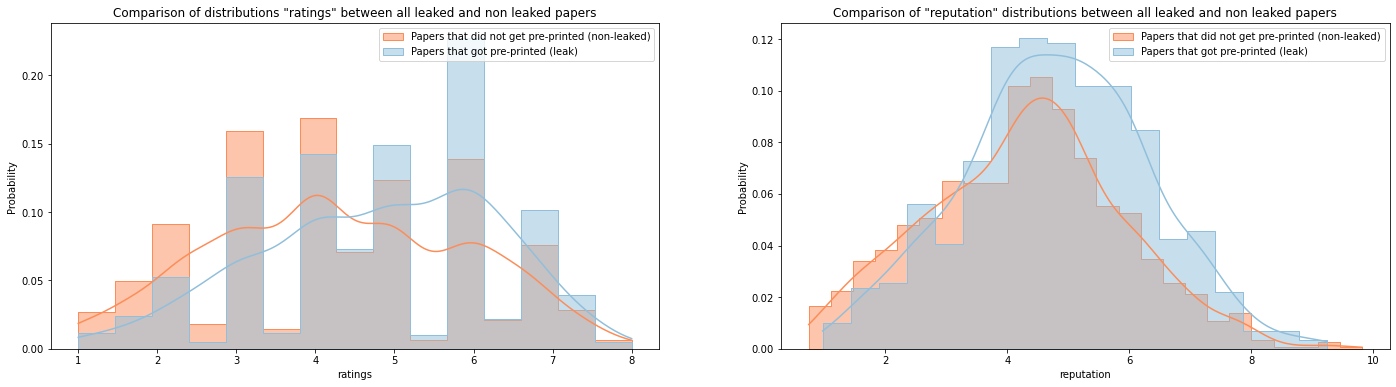

In [65]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))


# Plotting the comparison of distributions between all papers
plot_comparison_dist(non_standardized_leaked_ratings, 
                     'Papers that got pre-printed (leak)', 
                     non_standardized_non_leaked_ratings, 
                     'Papers that did not get pre-printed (non-leaked)', 
                     'Comparison of distributions "ratings" between all leaked and non leaked papers',
                     axs[0])

# Plotting the comparison of distributions between all papers
plot_comparison_dist(non_standardized_leaked_reputation, 
                     'Papers that got pre-printed (leak)', 
                     non_standardized_non_leaked_reputation, 
                     'Papers that did not get pre-printed (non-leaked)', 
                     'Comparison of "reputation" distributions between all leaked and non leaked papers',
                     axs[1])

#### *Subtask* 3.3.3

As we alluded before, the matching process did a pretty good job at balancing covariates. We then assume that our previous analysis (__step 2__) to check wether the pre-printing breaks double-blind submissions is not significant, and we should repeat the same analysis on the matched dataset.

### Task 3.4

At first, we compute the ATE (Average Treatment Effect) over the entire matched dataset. This score is one of the many methods to assess the effect of a treatment having a treated and a control group. The higher the score is, the more the impact of the treatment is significant.

In [66]:
# Computing the ATE and its 95% confidence interval
ate = (leaked['decisions'].values -non_leaked_matched['decisions'].values)
confidence_interval, ATE = compute_CI(ate, 95)

# Printing the result
print(f"ATE score: {ATE}\n95% confidence interval: {confidence_interval}\nNumber of samples: {len(ate)}")

ATE score: 0.03559322033898305
95% confidence interval: [0.020338983050847456, 0.05084745762711865]
Number of samples: 590


Mmmh... taking a look at this score, it doesn't seem that double-blind submissions have been broken: the average treatment effect, when the treatment consists in the paper being pre-printed, doesn't seem high!

### Task 3.5

We took into account every paper in the matching group, but actually the entire purpose of this analysis is to find out if the reviewers' judgment on a paper changes if they know that that paper comes from a known and accredited institution. It may happen that the reviewers are not biased __only__ if the paper doesn't come from a well known institution, in terms of their judgment, so let's build a matched dataset considering only the 2020 papers that come from one of those institutions.

#### *Subtask* 3.5.1

In [67]:
# Let's create our treatment and control groups
leaked_only_institution = df_with_prop[(df_with_prop['arxiv'] == 1) & (df_with_prop['has_top_institution'] == 1)]
non_leaked_only_institution = df_with_prop[(df_with_prop['arxiv'] == 0) & (df_with_prop['has_top_institution'] == 1)]

# Performing the matching
matching_only_institution = perform_matching(leaked_only_institution, non_leaked_only_institution)

# Let's take from the control group of papers (the one that didn't get pre-printed) only the matched ones
control_only_institution = list(matching_only_institution.values())
non_leaked_matched_only_institution = non_leaked_only_institution[non_leaked_only_institution['paper'].isin(control_only_institution)]

# Computing the "true" ratings (without standardization)
non_standardized_leaked_ratings = (leaked_only_institution['ratings'] * ratings_std) + ratings_mean
non_standardized_non_leaked_ratings_matched = (non_leaked_matched_only_institution['ratings'] * ratings_std) + ratings_mean
non_standardized_non_leaked_ratings = (non_leaked_only_institution['ratings'] * ratings_std) + ratings_mean

# Computing the "true" reputations (without standardization)
non_standardized_leaked_reputation = (leaked_only_institution['reputation'] * ratings_std) + ratings_mean
non_standardized_non_leaked_reputation_matched = (non_leaked_matched_only_institution['reputation'] * ratings_std) + ratings_mean
non_standardized_non_leaked_reputation = (non_leaked_only_institution['reputation'] * ratings_std) + ratings_mean

Let's see if, even in this case, we matched all treated papers with a control one, and let's plot the distribution for the variables "ratings" and "reputation" even in this case.

In [68]:
print(f"Number of 2020 papers from a top institution that got pre-printed: {leaked_only_institution.shape[0]}\nNumber of 2020 papers from a top institution that got pre-printed and matched: {len(matching_only_institution.keys())}")

Number of 2020 papers from a top institution that got pre-printed: 161
Number of 2020 papers from a top institution that got pre-printed and matched: 161


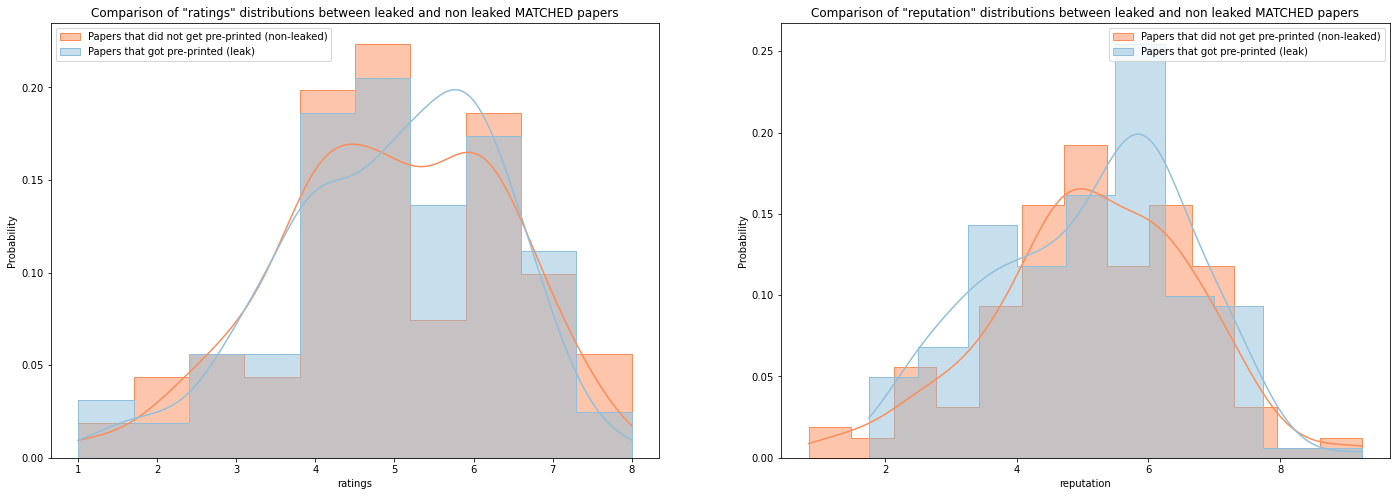

In [69]:
fig, axs = plt.subplots(1, 2, figsize = (24, 8))

# Plotting the comparison of "ratings" distributions between matched papers
plot_comparison_dist(non_standardized_leaked_ratings, 
                     'Papers that got pre-printed (leak)', 
                     non_standardized_non_leaked_ratings_matched, 
                     'Papers that did not get pre-printed (non-leaked)', 
                     'Comparison of "ratings" distributions between leaked and non leaked MATCHED papers',
                     axs[0])
axs[0].legend(loc = 'upper left')
# Plotting the comparison of "reputation" distributions between matched papers
plot_comparison_dist(non_standardized_leaked_reputation, 
                     'Papers that got pre-printed (leak)', 
                     non_standardized_non_leaked_reputation_matched, 
                     'Papers that did not get pre-printed (non-leaked)', 
                     'Comparison of "reputation" distributions between leaked and non leaked MATCHED papers',
                     axs[1])

Even in this case, we can notice that the two distributions are quite similar. Of course, given the smaller number of samples, the matching is slightly worse than the previous one, but the distributions are still more similar than the ones computed over the entire dataset (considering only the top-institution papers), without the matching.

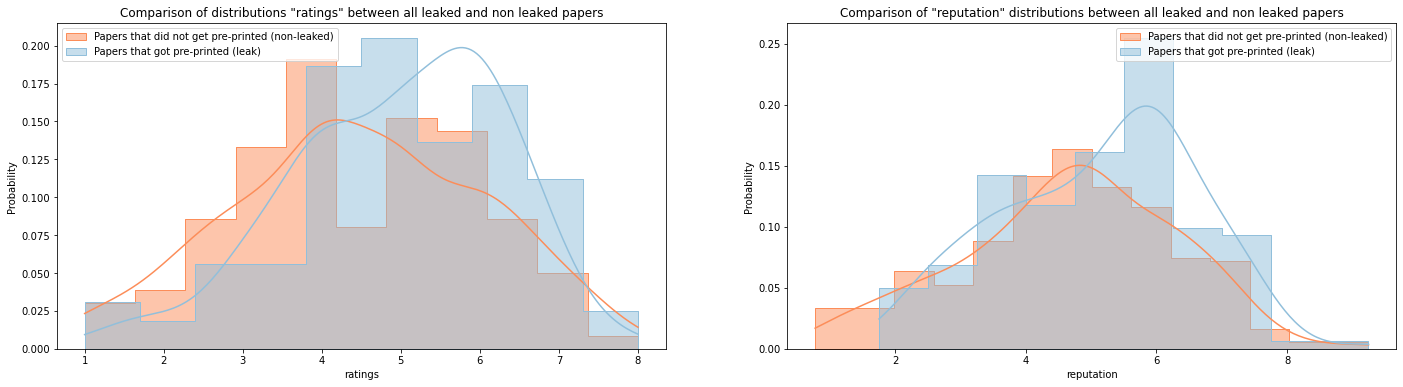

In [70]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))


# Plotting the comparison of distributions between all papers
plot_comparison_dist(non_standardized_leaked_ratings, 
                     'Papers that got pre-printed (leak)', 
                     non_standardized_non_leaked_ratings, 
                     'Papers that did not get pre-printed (non-leaked)', 
                     'Comparison of distributions "ratings" between all leaked and non leaked papers',
                     axs[0])

# Plotting the comparison of distributions between all papers
plot_comparison_dist(non_standardized_leaked_reputation, 
                     'Papers that got pre-printed (leak)', 
                     non_standardized_non_leaked_reputation, 
                     'Papers that did not get pre-printed (non-leaked)', 
                     'Comparison of "reputation" distributions between all leaked and non leaked papers',
                     axs[1])

In [71]:
# Computing the Average Treatment Effect on the new matched dataset, and its 95% confidence interval
ate = (leaked_only_institution['decisions'].values -non_leaked_matched_only_institution['decisions'].values)
confidence_interval, ATE = compute_CI(ate, 95)

# Printing the result
print(f"ATE score: {ATE}\n95% confidence interval: {confidence_interval}\nNumber of samples: {len(ate)}")

ATE score: 0.09937888198757763
95% confidence interval: [0.055900621118012424, 0.14906832298136646]
Number of samples: 161


#### *Subtask* 3.5.2

Let's analyze the result we got:

- The ATE score is positive: this means that top-institutions treated papers, in general, have been accepted more than not treated papers coming from the same institutions.
- The ATE score, when considering just the papers coming from the top institutions, is higher than the same score computed over the entire collection of papers (after matching, of course). This means that, if the paper comes from a top institutions, it has more chances to be accepted if it is pre-printed. But is this result significant?

It would be interesting to see what the ATE score without taking into account the top institutions. 
If this score is lower than the one computed across all papers, maybe we could take the increase of the ATE score for top institutions as evidence of pre-printing breaking double blind submissions.

In [72]:
# Creating the treatment and the control group (2020 papers don't come from a top institution)
leaked_only_no_institution = df_with_prop[(df_with_prop['arxiv'] == 1) & (df_with_prop['has_top_institution'] == 0)]
non_leaked_only_no_institution = df_with_prop[(df_with_prop['arxiv'] == 0) & (df_with_prop['has_top_institution'] == 0)]

# Performing the matching once again
no_institution_matching = perform_matching(leaked_only_no_institution,non_leaked_only_no_institution)

# Let's take from the control group of papers (the one that didn't get pre-printed) only the matched ones
control_only_no_institution = list(no_institution_matching.values())
control_matched_df = non_leaked_only_no_institution[non_leaked_only_no_institution['paper'].isin(control_only_no_institution)]

In [73]:
print(f"Number of 2020 papers from a non top-institution that got pre-printed: {leaked_only_no_institution.shape[0]}\nNumber of 2020 papers from a non top-institution that got pre-printed and matched: {len(no_institution_matching.keys())}")

Number of 2020 papers from a non top-institution that got pre-printed: 429
Number of 2020 papers from a non top-institution that got pre-printed and matched: 429


In [74]:
# Computing and printing the ATE score for the papers coming from a non top-institution and its confidence interval
ate = (leaked_only_no_institution['decisions'].values -control_matched_df['decisions'].values)
confidence_interval, ATE = compute_CI(ate, 95)
print(f"ATE score: {ATE}\n95% confidence interval: {confidence_interval}\nNumber of samples: {len(ate)}")

ATE score: 0.013986013986013986
95% confidence interval: [0.004662004662004662, 0.02564102564102564]
Number of samples: 429


The ATE score for non top institutions is indeed lower than the general ATE score! Let us summarize our results: 
- ATE score (all institutions considered) :  
    - Mean :`0.036` 
    - Confidence Interval: `[0.020, 0.051]`
    - Number of matched samples: `590`
- ATE score (top institutions considered) :  
    - Mean :`0.099` 
    - Confidence Interval: `[0.056, 0.149]`
    - Number of matched samples: `161`
- ATE score (non-top institutions considered) :  
    - Mean :`0.014` 
    - Confidence Interval: `[0.005, 0.026]`
    - Number of matched samples: `429`



We do observe a significant increase of the average treatment effect in the population of top-institution papers. Unfortunately, we should also consider the following: 
- The ATE score, with respect only to the papers coming from the top institutions, was computed across a sample of matched papers of considerably reduced size. This results in a huge increase in the width of the confidence interval
  making us less confident about the obtained result.
- Ideally, the ATE score assesses the treatment effect on identical samples. However, a paper cannot be pre-printed and not pre-printed at the same time. Hence, the efficency of the ATE metric is highly dependent on the quality of the propensity score matching done previously.  At first glance, the matching seems to be pretty spot on, but since it isn't perfect, it could lead to a loss of accuracy for small values of the ATE. 
  
For these reasons, we cannot say that the ATE is evidence enough for the breaking of double blind submissions. We are not saying that double blind submissions are not broken, but this ATE score can just be considered as a hint in this sense, not as a complete evidence. Maybe, with a more significant number of papers to analyze, we could be more confident about our result.
